# Use Case 8: Outliers

When analyzing data, it's often crucial to identify outliers—extremely high or low data points that can greatly affect the overall conclusions. In this use case, we demonstrate how to utilize the Blacksheep package to find these outliers in the CPTAC (Clinical Proteomic Tumor Analysis Consortium) data. We'll focus on a specific phenomenon reported in the CPTAC breast cancer study. The study revealed that tumors classified as HER-2 enriched frequently showed exceptionally high abundance of ERBB2 phosphorylation, protein, and mRNA. We will validate this observation using an independent cohort of breast cancer tumors included in the cptac package.

## Step 1: Importing packages and setting up the notebook

First, we import the necessary Python packages for data analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next, we'll import the blacksheep and cptac packages to grab our proteomic and clinical data. The blacksheep package needs to be installed separately, which can be done via pip command: pip install blksheep. (Not blacksheep)

In [2]:
import blacksheep
import cptac

brca = cptac.Brca()
clinical = brca.get_clinical('mssm')
proteomics = brca.get_proteomics('umich')

## Step 2: Binarize Data

The Blacksheep package requires the annotations to be binary variables. The 'histologic_type' of our cptac tumors is divided into different types. To create a binary table of these histologic types, we use the binarize_annotations function from blacksheep. The resultant binary table is referred to as 'annotations'.

In [3]:
annotations = clinical[['histologic_type']].copy()
annotations = blacksheep.binarize_annotations(annotations)
annotations.head()

,histologic_type_Inflitrating Ductal Carcinoma,histologic_type_Inflitrating Lobular Carcinoma,histologic_type_Other (specify),"histologic_type_other, specify",histologic_type_IDC and DCIS,histologic_type_Infiltrating Ductal and Lobular Carcinoma,histologic_type_Mucinous Carcinoma,histologic_type_Infiltrating Ductal and Mucinous Carcinoma,histologic_type_invasive ductal carcinoma with extensive high-grade DCIS with comedonecrosis and features of papillary carcinoma,histologic_type_Mixed ductal and lobular features,histologic_type_Triple Negative
Patient_ID,,,,,,,,,,,
01BR001,Inflitrating Ductal Carcinoma,not-Inflitrating Lobular Carcinoma,not-Other (specify),"not-other, specify",not-IDC and DCIS,not-Infiltrating Ductal and Lobular Carcinoma,not-Mucinous Carcinoma,not-Infiltrating Ductal and Mucinous Carcinoma,not-invasive ductal carcinoma with extensive h...,not-Mixed ductal and lobular features,not-Triple Negative
01BR008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01BR009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01BR010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01BR015,Inflitrating Ductal Carcinoma,not-Inflitrating Lobular Carcinoma,not-Other (specify),"not-other, specify",not-IDC and DCIS,not-Infiltrating Ductal and Lobular Carcinoma,not-Mucinous Carcinoma,not-Infiltrating Ductal and Mucinous Carcinoma,not-invasive ductal carcinoma with extensive h...,not-Mixed ductal and lobular features,not-Triple Negative


## Step 3: Perform Outlier Analysis

Now that our data frames are in the correct format, we perform the outlier analysis using the deva function in the blacksheep package. This function takes the proteomics data frame (transposed to meet the function's requirements) and the annotations data frame that includes binarized columns. The function returns two objects:

1. A data object ('outliers') with a dataframe indicating whether a sample is an outlier for a specific protein.
2. A data object ('qvalues') with a dataframe showing the Q Values. These indicate if a gene shows an enrichment in outliers for a specific subset of tumors as defined in annotations.

In [4]:
outliers, qvalues = blacksheep.deva(proteomics.transpose(),
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False,
                                      frac_filter=0.3)

cptac warning: Your version of cptac (1.5.1) is out-of-date. Latest is 1.5.0. Please run 'pip install --upgrade cptac' to update it. (C:\Users\sabme\anaconda3\lib\threading.py, line 910)


## Step 4: Inspect Results

Because these two tables that are returned are quite complex, we will now look at each of these individually.

The outliers table indicates whether each sample is an outlier for a particular gene. In this use case, we will focus on ERBB2. The first line below simplifies the index for each row by dropping the database id and leaving the gene name. We also only print off a portion of the table for brevity.

In [5]:
outliers.df.index = outliers.df.index.droplevel('Database_ID')
erbb2_outliers = outliers.df[outliers.df.index.str.match('ERBB2')]
erbb2_outliers.iloc[:, :8]

,01BR001_outliers,01BR008_outliers,01BR009_outliers,01BR010_outliers,01BR015_outliers,01BR017_outliers,01BR018_outliers,01BR020_outliers
Name,,,,,,,,
ERBB2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In the chart above you can see that most of the samples have 0, indiciating that the sample is not an outlier for ERBB2 protein abundance. 01BR017, however, has a 1, indicating that particular sample is an outlier.

The Outliers table contains boolean columns for both outlier and notOutliers. The notOutliers columns are redundant so we will remove them.

In [6]:
erbb2_outliers = erbb2_outliers.loc[:,~erbb2_outliers.columns.str.endswith('_notOutliers')]

We can now complile a list of all the samples that were considered to be outliers.

In [7]:
outlier_list = erbb2_outliers.columns[erbb2_outliers.isin([1.0]).all()].tolist()
print(outlier_list)

['01BR017_outliers', '05BR026_outliers', '06BR006_outliers', '09BR004_outliers', '09BR005_outliers', '11BR004_outliers', '11BR010_outliers', '11BR011_outliers', '11BR028_outliers', '11BR030_outliers', '11BR038_outliers', '11BR060_outliers', '11BR075_outliers', '18BR009_outliers', '21BR001_outliers', '22BR005_outliers']


## Step 5: Visualizing Outliers
To understand what this means, we will plot the proteomics data for the ERBB2 gene and label the outlier samples. Before we graph the result we will join the proteomics and clinical data, isolating the histologic type and ERBB2.

In [8]:
combined_data = brca.join_metadata_to_omics(metadata_name="clinical",
                                            metadata_source="mssm",
                                            metadata_cols=["histologic_type"],
                                            omics_name="proteomics", 
                                            omics_source="umich",
                                            omics_genes=['ERBB2'])

We will now create the graph.

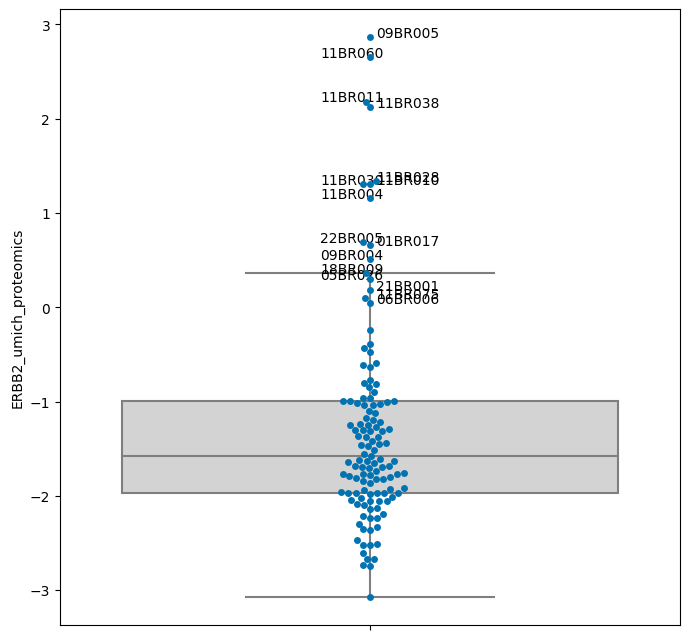

In [9]:
plt.figure(figsize=(8, 8))
sns.set_palette('colorblind')
ax = sns.boxplot(data=combined_data, showfliers=False, y='ERBB2_umich_proteomics', color='lightgray')
left = False
# This for loop labels all the specific outlier data points.
for sample in outlier_list:
    if left:
        position = -0.08
        left = False
    else:
        position = 0.01
        left = True
    sample = sample.split("_")[0]
    ax.annotate(sample, (position, combined_data.transpose()[sample].values[1]))
ax = sns.swarmplot(data=combined_data, y='ERBB2_umich_proteomics')
plt.show()

As you can see from this graph, the samples we labeled, which had a 1.0 in the outliers table were all located at the top of the graph, indicating they are very highly expressed.

## Step 6: Looking at the Qvalue table

Let's now take a look at the Qvalues table. Remember that the qvalues table indicates the probability that a gene shows an enrichment in outliers for categories defined in our annotation dataframe.

In [10]:
qvalues.df.head()

,,fisherFDR_histologic_type_Inflitrating Ductal Carcinoma_not-Inflitrating Ductal Carcinoma,fisherFDR_histologic_type_Inflitrating Lobular Carcinoma_Inflitrating Lobular Carcinoma,fisherFDR_histologic_type_Other (specify)_Other (specify)
Name,Database_ID,,,
HSPB6,ENSP00000004982.3,NaN,0.019135,NaN
SKAP2,ENSP00000005587.2,NaN,NaN,0.178671
UBR7,ENSP00000013070.6,NaN,NaN,0.178671
PTBP1,ENSP00000014112.5,NaN,NaN,0.178671
HEBP1,ENSP00000014930.4,NaN,0.062689,NaN


This table includes all the q-values. Before really analyzing the table we will want to remove any insignificant q-values. For our purposes we will remove any q-values that are greater than 0.05.

In [11]:
for col in qvalues.df.columns:
    qvalues.df.loc[qvalues.df[col] > 0.05, col] = np.nan

We will now isolate the ERBB2 gene.

In [12]:
qvalues.df.index = qvalues.df.index.droplevel('Database_ID')
qvalues = qvalues.df[qvalues.df.index.str.match('ERBB2')]
erbb2_qvalues = qvalues.reset_index()['Name'] == 'ERBB2'
qvalues = qvalues.reset_index()[erbb2_qvalues]
qvalues.head()

,Name,fisherFDR_histologic_type_Inflitrating Ductal Carcinoma_not-Inflitrating Ductal Carcinoma,fisherFDR_histologic_type_Inflitrating Lobular Carcinoma_Inflitrating Lobular Carcinoma,fisherFDR_histologic_type_Other (specify)_Other (specify)


Here we see that none of the histologic types have a significant enrichment, which is exactly what is to be expected. To visualize this pattern, we will create a graph similiar to the one above, but with each of the categories in the histologic type category differentially colored. (Since there are many categories, some extra steps are taken to make the graph look less cluttered).

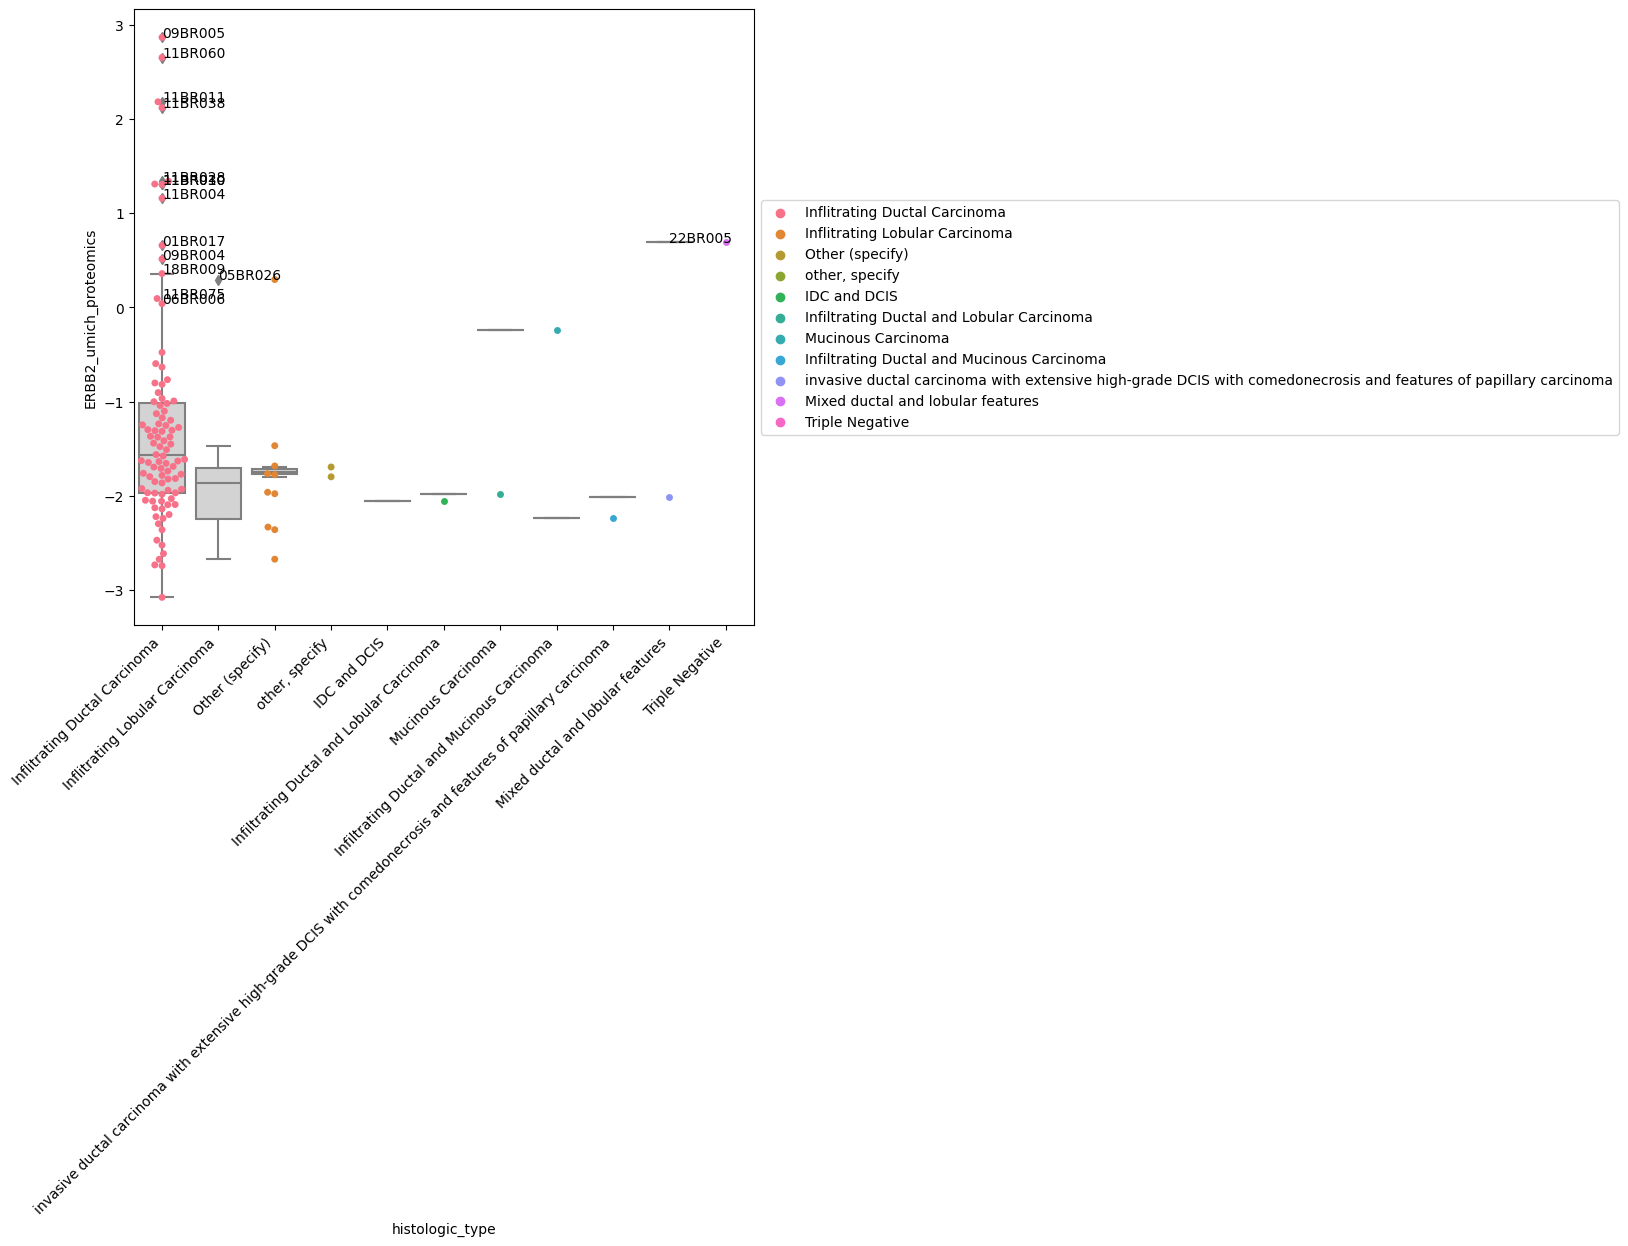

In [13]:
# Setup
plt.figure(figsize=(8, 8))
sns.set_palette('colorblind')
cols = {'Inflitrating Ductal Carcinoma': 0, 'Inflitrating Lobular Carcinoma':1, 'Other (specify)':2, 'other, specify':3, 'IDC and DCIS':4, 'Infiltrating Ductal and Lobular Carcinoma':5, 'Mucinous Carcinoma':6, 'Infiltrating Ductal and Mucinous Carcinoma':7, 'invasive ductal carcinoma with extensive high-grade DCIS with comedonecrosis and features of papillary carcinoma':8, 'Mixed ductal and lobular features':9, 'Triple Negative':10}

# Plotting
ax = sns.boxplot(data=combined_data, y='ERBB2_umich_proteomics', x='histologic_type', color='lightgray')
ax = sns.swarmplot(data=combined_data, y='ERBB2_umich_proteomics',x='histologic_type', hue='histologic_type')

# Rotate x-labels for clarity
plt.xticks(rotation=45, ha="right") # rotation by 45 degrees

# Add annotations for outliers
for sample in outlier_list:
    try:
        sample = sample.split("_")[0]
        ax.annotate(sample, (cols[combined_data.transpose()[sample].values[0]], combined_data.transpose()[sample].values[1]))
    except KeyError:
        continue

# Move the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout() # Adjust layout to prevent any overlaps
plt.show()

## Additional Applications

We have just walked through one example of how you might use the Outlier Analysis. Using this same approach, you can run the outlier analysis on a number of different clinical attributes, cohorts, and omics data. For example, you may look for outliers within the transcriptomics of the Endometrial cancer type using the clinical attribute of histologic_type. You can also look at more than one clinical attribute at a time by appending more attributes to your annotations table, or you can look for downregulated omics by chaning the 'up_or_down' variable of the run_outliers function.